In [26]:
import pandas as pd
import os

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))

In [27]:
df.head()

,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High


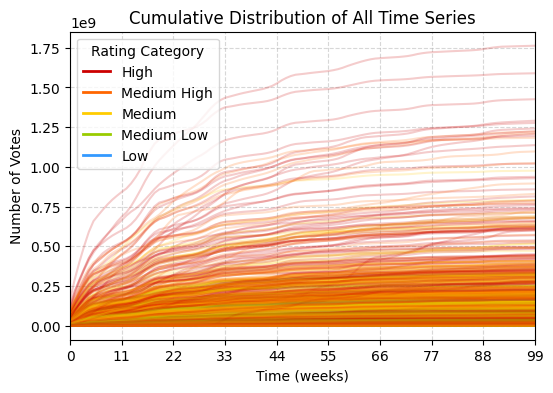

In [28]:
cols_to_drop = [
    'id', 'rating', 'rating_category', 'genre'
]

# Plot the distribution of all time series in df
import matplotlib.pyplot as plt

color_map = {
    'High': '#CC0000',      # Dark Red
    'Medium High': '#FF6600',   # Bright Orange
    'Medium': '#FFCC00',   # Yellow
    'Medium Low': '#99CC00', # Lime Green
    'Low': '#3399FF'         # Sky Blue
}

plt.figure(figsize=(6, 4))
for i in range(len(df)):
    df_inc = df.drop(columns=cols_to_drop).iloc[i].cumsum()
    rating_cat = df.iloc[i]['rating_category']
    color = color_map.get(rating_cat, 'gray')
    plt.plot(df_inc, alpha=0.2, color=color)
plt.xlabel('Time (weeks)')
plt.ylabel('Number of Votes')
plt.title('Cumulative Distribution of All Time Series')
plt.grid(alpha=0.5, linestyle='--')
# plt.yscale('log')
# Reduce xticks
plt.xticks(ticks=range(0, df.shape[1]-len(cols_to_drop), 11),
           labels=range(0, df.shape[1]-len(cols_to_drop), 11))
# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color_map['High'], lw=2, label='High'),
    Line2D([0], [0], color=color_map['Medium High'], lw=2, label='Medium High'),
    Line2D([0], [0], color=color_map['Medium'], lw=2, label='Medium'),
    Line2D([0], [0], color=color_map['Medium Low'], lw=2, label='Medium Low'),
    Line2D([0], [0], color=color_map['Low'], lw=2, label='Low')
]
plt.legend(handles=legend_elements, title='Rating Category')
plt.xlim(0, 99)
plt.show()

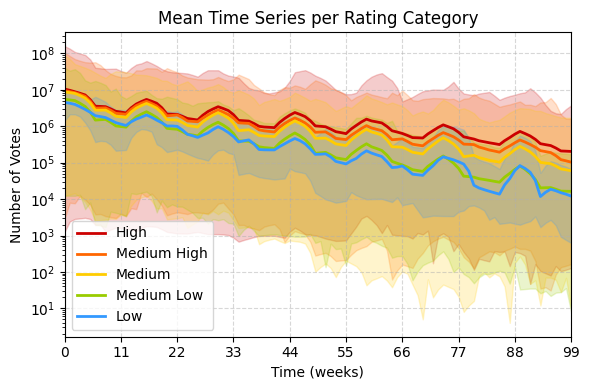

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

cols_to_drop = ['id', 'rating', 'rating_category', 'genre']

# Define color map
color_map = {
    'High': '#CC0000',         # Dark Red
    'Medium High': '#FF6600',  # Bright Orange
    'Medium': '#FFCC00',       # Yellow
    'Medium Low': '#99CC00',   # Lime Green
    'Low': '#3399FF'           # Sky Blue
}

# df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Prepare plot
plt.figure(figsize=(6, 4))

# Get time-series columns
ts_cols = [c for c in df.columns if c not in cols_to_drop]
x = np.arange(len(ts_cols))

# plt.ylim(1, 10e8)
# Compute and plot mean + std per rating category
for category, color in color_map.items():
    subset = df[df['rating_category'] == category]
    if subset.empty:
        continue  # skip if no data for this category
    ts_data = subset[ts_cols].to_numpy()
    mean_ts = ts_data.mean(axis=0)
    # std_ts = ts_data.std(axis=0)
    min_ts = ts_data.min(axis=0)
    max_ts = ts_data.max(axis=0)
    # print(std_ts.shape, mean_ts.shape)
    
    plt.plot(x, mean_ts, color=color, lw=2, label=category)
    plt.fill_between(
        # x, mean_ts - std_ts, mean_ts + std_ts,
        x, min_ts, max_ts,
        color=color, alpha=0.2
    )

# Formatting
plt.xlabel('Time (weeks)')
plt.ylabel('Number of Votes')
plt.title('Mean Time Series per Rating Category')
plt.grid(alpha=0.5, linestyle='--')
plt.xticks(ticks=range(0, len(ts_cols), 11), labels=range(0, len(ts_cols), 11))
plt.xlim(0, 99)
# plt.ylim(1, 10e7)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

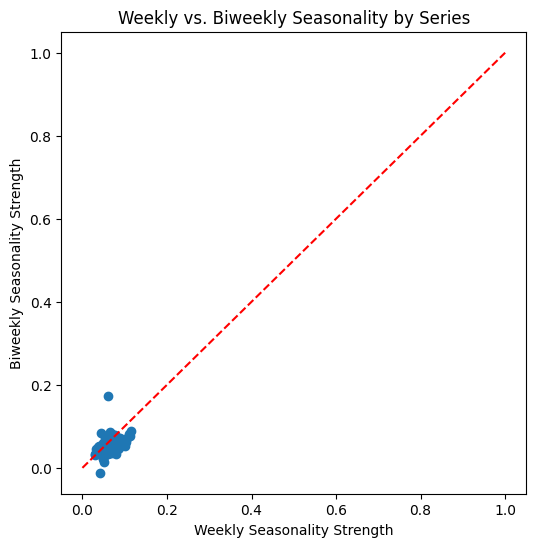

Average weekly strength: 0.066
Average biweekly strength: 0.055
29.0% of series show stronger biweekly seasonality.


In [30]:
from statsmodels.tsa.seasonal import STL
import numpy as np

def seasonal_strength(series, period):
    """Compute Hyndman's seasonal strength measure for a given period."""
    stl = STL(series, period=period, robust=True).fit()
    var_r = np.var(stl.resid)
    var_s_plus_r = np.var(stl.seasonal + stl.resid)
    return 1 - var_r / var_s_plus_r

strengths = []

for i in range(100):
    s7 = seasonal_strength(df[f'{i}'], 7)
    s14 = seasonal_strength(df[f'{i}'], 14)
    strengths.append({'series': f'{i}', 'weekly_strength': s7, 'biweekly_strength': s14})

strengths_df = pd.DataFrame(strengths)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(strengths_df['weekly_strength'], strengths_df['biweekly_strength'])
plt.plot([0,1],[0,1],'r--')
plt.xlabel('Weekly Seasonality Strength')
plt.ylabel('Biweekly Seasonality Strength')
plt.title('Weekly vs. Biweekly Seasonality by Series')
plt.show()

mean_weekly = strengths_df['weekly_strength'].mean()
mean_biweekly = strengths_df['biweekly_strength'].mean()

print(f"Average weekly strength: {mean_weekly:.3f}")
print(f"Average biweekly strength: {mean_biweekly:.3f}")

# How many show stronger biweekly
ratio = (strengths_df['biweekly_strength'] > strengths_df['weekly_strength']).mean()
print(f"{ratio:.1%} of series show stronger biweekly seasonality.")


In [31]:
df['rating_category'].unique()

array(['High', 'Medium High', 'Medium', 'Medium Low', 'Low'], dtype=object)

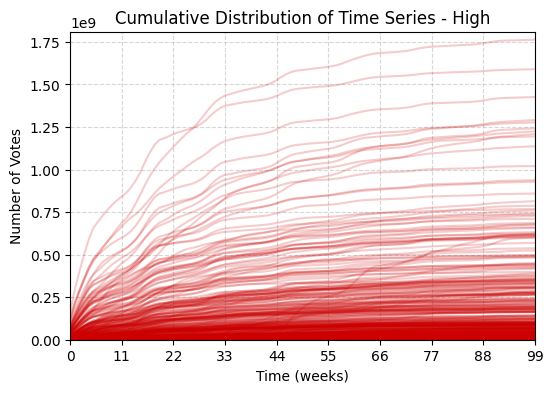

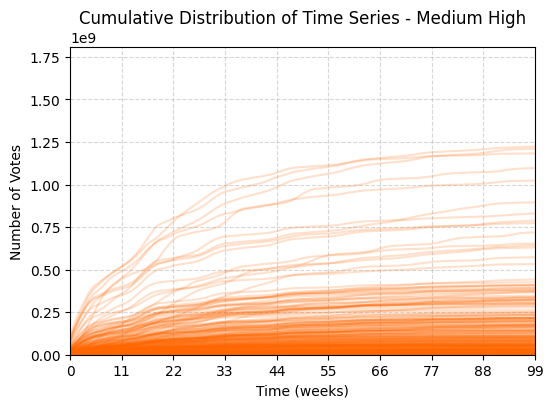

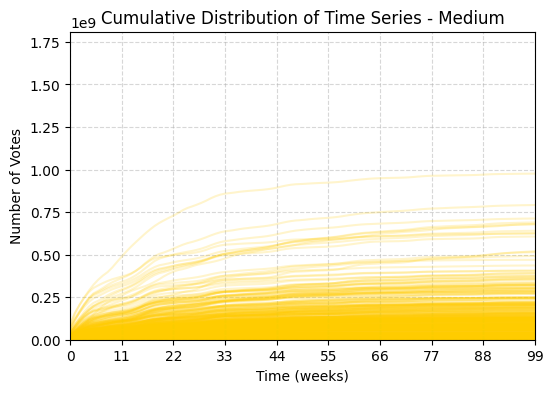

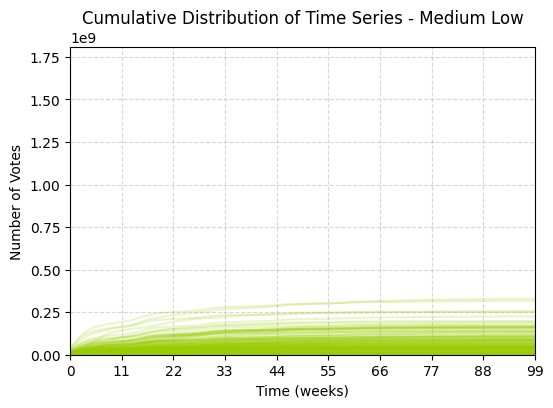

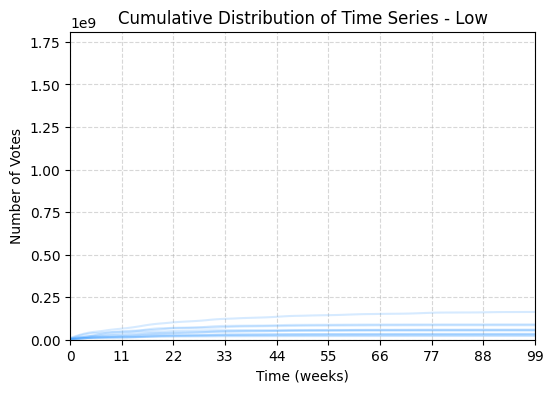

In [32]:
# Plot distributions for each rating category separately
rating_categories = df['rating_category'].unique()
for category in rating_categories:
    plt.figure(figsize=(6, 4))
    subset = df[df['rating_category'] == category]
    for i in range(len(subset)):
        df_inc = subset.drop(columns=cols_to_drop).iloc[i].cumsum()
        plt.plot(df_inc, alpha=0.2, color=color_map.get(category, 'gray'))
    plt.xlabel('Time (weeks)')
    plt.ylabel('Number of Votes')
    plt.title(f'Cumulative Distribution of Time Series - {category}')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xticks(ticks=range(0, df.shape[1]-len(cols_to_drop), 11),
           labels=range(0, df.shape[1]-len(cols_to_drop), 11))
    # plt.yscale('log')
    plt.xlim(0, 99)
    plt.ylim(0, 1.81e9)
    plt.show()

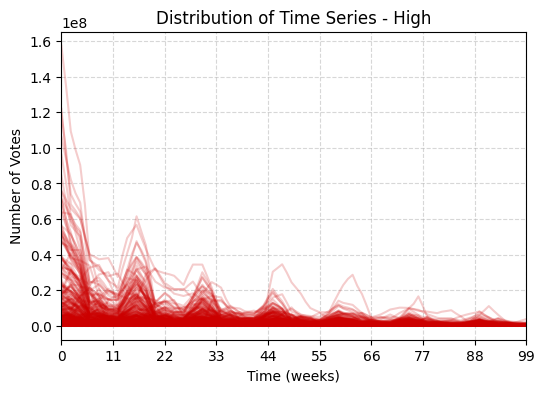

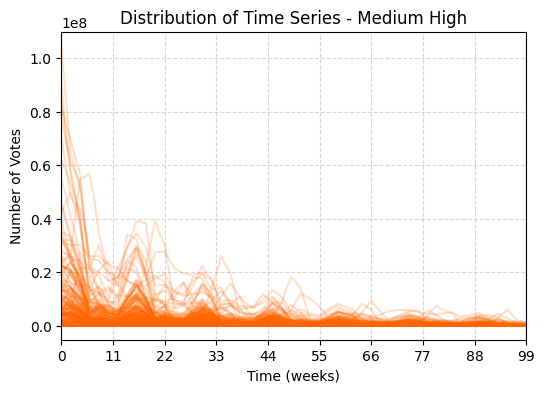

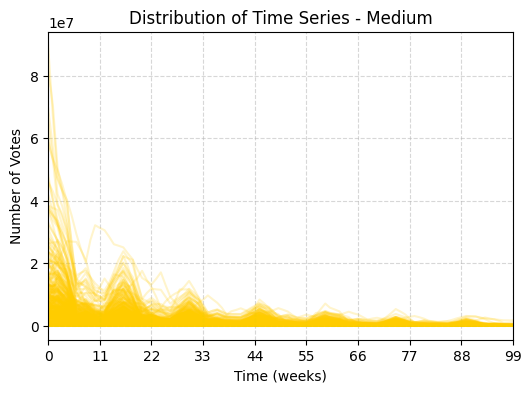

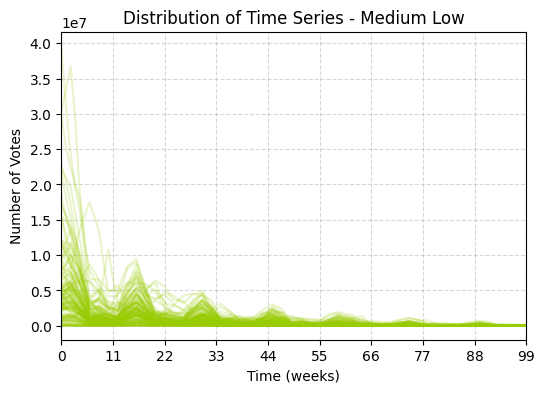

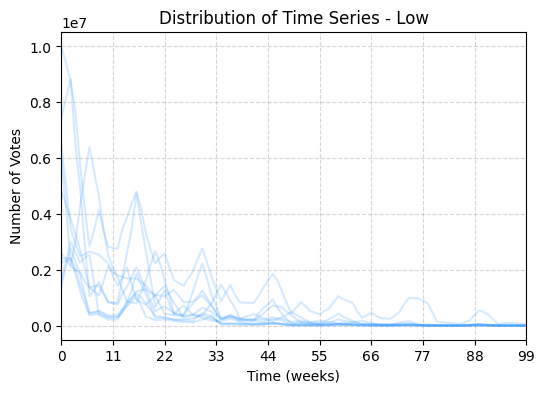

In [33]:
# Plot distributions for each rating category separately
rating_categories = df['rating_category'].unique()
for category in rating_categories:
    plt.figure(figsize=(6, 4))
    subset = df[df['rating_category'] == category]
    for i in range(len(subset)):
        # df_inc = subset.drop(columns=cols_to_drop).iloc[i].cumsum()
        plt.plot(
            subset.drop(columns=cols_to_drop).iloc[i],
            alpha=0.2,
            color=color_map.get(category, 'gray')
        )
    plt.xlabel('Time (weeks)')
    plt.ylabel('Number of Votes')
    plt.title(f'Distribution of Time Series - {category}')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xticks(ticks=range(0, df.shape[1]-len(cols_to_drop), 11),
           labels=range(0, df.shape[1]-len(cols_to_drop), 11))
    # plt.yscale('log')
    plt.xlim(0, 99)
    # plt.ylim(0, 1.751e9)
    plt.show()

In [34]:
df.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '93', '94', '95', '96', '97', '98', '99', 'rating', 'genre',
       'rating_category'],
      dtype='object', length=104)

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_87210/4034710752.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


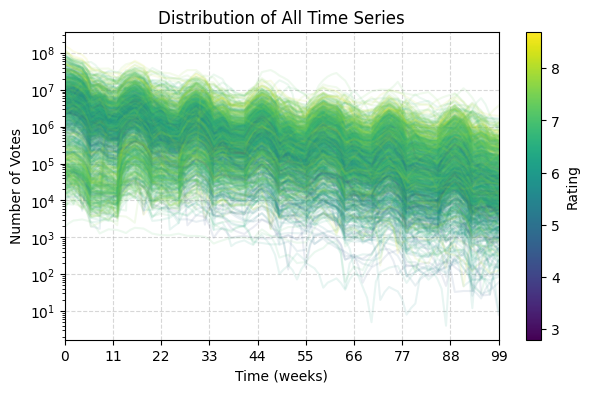

In [35]:
# Plot distributions with colormapping on rating continuous feature
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Normalize ratings to [0, 1] for colormap
norm = plt.Normalize(df['rating'].min(), df['rating'].max())
cmap = cm.get_cmap('viridis')
colors = cmap(norm(df['rating']))
plt.figure(figsize=(7, 4))
for i in range(len(df)):
    df_inc = df.drop(columns=cols_to_drop).iloc[i]
    rating_cat = df.iloc[i]['rating_category']
    color = colors[i]
    plt.plot(df_inc, alpha=0.1, color=color)
plt.xlabel('Time (weeks)')
plt.ylabel('Number of Votes')
plt.title('Distribution of All Time Series')
plt.grid(alpha=0.5, linestyle='--')
# plt.yscale('log')
# Reduce xticks
plt.xticks(ticks=range(0, df.shape[1]-len(cols_to_drop), 11),
           labels=range(0, df.shape[1]-len(cols_to_drop), 11))
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Rating')
plt.xlim(0, 99)
plt.yscale('log')
plt.show()

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_87210/609362135.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


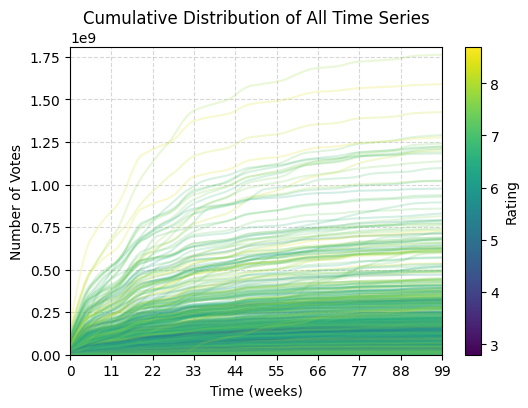

In [36]:
# Plot distributions with colormapping on rating continuous feature
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Normalize ratings to [0, 1] for colormap
norm = plt.Normalize(df['rating'].min(), df['rating'].max())
cmap = cm.get_cmap('viridis')
colors = cmap(norm(df['rating']))
plt.figure(figsize=(6, 4))
for i in range(len(df)):
    df_inc = df.drop(columns=cols_to_drop).iloc[i].cumsum()
    rating_cat = df.iloc[i]['rating_category']
    color = colors[i]
    plt.plot(df_inc, alpha=0.2, color=color)
plt.xlabel('Time (weeks)')
plt.ylabel('Number of Votes')
plt.title('Cumulative Distribution of All Time Series')
plt.grid(alpha=0.5, linestyle='--')
# plt.yscale('log')
# Reduce xticks
plt.xticks(ticks=range(0, df.shape[1]-len(cols_to_drop), 11),
           labels=range(0, df.shape[1]-len(cols_to_drop), 11))
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Rating')
plt.xlim(0, 99)
plt.ylim(0, 1.81e9)
# plt.yscale('log')
plt.show()

In [37]:
import stumpy as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_matrix_profile(time_series, mp, m):
    """
    Plots a single time series and its matrix profile, including a legend
    for motifs and discords.

    Args:
        time_series (np.array): The original time series.
        mp (np.array): The computed matrix profile.
        m (int): The subsequence length.
    """
    _, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))
    
    # Plot the original time series
    ax1.plot(time_series, color='tab:grey')
    ax1.set_title('Time Series', fontsize=16)
    ax1.set_ylabel('Value', fontsize=12)
    ax1.set_xlabel('Time Step', fontsize=12)
    ax1.grid(alpha=0.5, linestyle='--')
    ax1.set_xlim(0, len(time_series))
    
    # Plot the matrix profile
    ax2.plot(mp, color='tab:grey')
    ax2.set_title('Matrix Profile', fontsize=16)
    ax2.set_xlabel('Subsequence Index', fontsize=12)
    ax2.set_ylabel('Matrix Profile Value', fontsize=12)
    ax2.set_xlim(0, len(mp))
    
    # Find the top 3 motifs (lowest value) and discords (highest value)
    mp_motif_indeces = np.argsort(mp)[:3]
    mp_discord_indeces = np.argsort(mp)[-3:]

    # Plot top 3 motif segments
    for mp_motif_index in mp_motif_indeces:
        # Highlight motif portion
        ax1.axvspan(
            mp_motif_index, mp_motif_index + m,
            facecolor='orange', alpha=0.3
        )
        # Add start and end lines
        ax1.axvline(mp_motif_index, color='orange', linestyle='--', alpha=0.7)
        ax1.axvline(mp_motif_index + m, color='orange', linestyle='--', alpha=0.7)
    
    # Plot discord segment
    for mp_discord_index in mp_discord_indeces:
        ax1.axvspan(
            mp_discord_index, mp_discord_index + m,
            facecolor='red', alpha=0.3, 
        )
        # Add start and end lines
        ax1.axvline(mp_discord_index, color='red', linestyle='--', alpha=0.7)
        ax1.axvline(mp_discord_index + m, color='red', linestyle='--', alpha=0.7)
    
    # On matrix profile plot, mark motif/discord points
    for mp_motif_index in mp_motif_indeces:
        ax2.plot(mp_motif_index, mp[mp_motif_index], 'o', color='orange')
    for mp_discord_index in mp_discord_indeces:
        ax2.plot(mp_discord_index, mp[mp_discord_index], 'o', color='red')

    # Add legend to the time series plot
    motif_patch = mpatches.Patch(color='orange', alpha=0.3, label='Motifs')
    discord_patch = mpatches.Patch(color='red', alpha=0.3, label='Discords')
    ax1.legend(handles=[motif_patch, discord_patch])
    ax2.legend(handles=[motif_patch, discord_patch])
    

    plt.tight_layout()
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()

Processing Time Series #1...
  - The most repeating motif starts at index: 1
  - The most significant discord (anomaly) starts at index: 19
----------------------------------------
Processing Time Series #2...
  - The most repeating motif starts at index: 2
  - The most significant discord (anomaly) starts at index: 45
----------------------------------------
Processing Time Series #3...
  - The most repeating motif starts at index: 27
  - The most significant discord (anomaly) starts at index: 2
----------------------------------------
Processing Time Series #4...
  - The most repeating motif starts at index: 7
  - The most significant discord (anomaly) starts at index: 59
----------------------------------------
Processing Time Series #5...
  - The most repeating motif starts at index: 19
  - The most significant discord (anomaly) starts at index: 8
----------------------------------------
Processing Time Series #6...
  - The most repeating motif starts at index: 1
  - The most signi

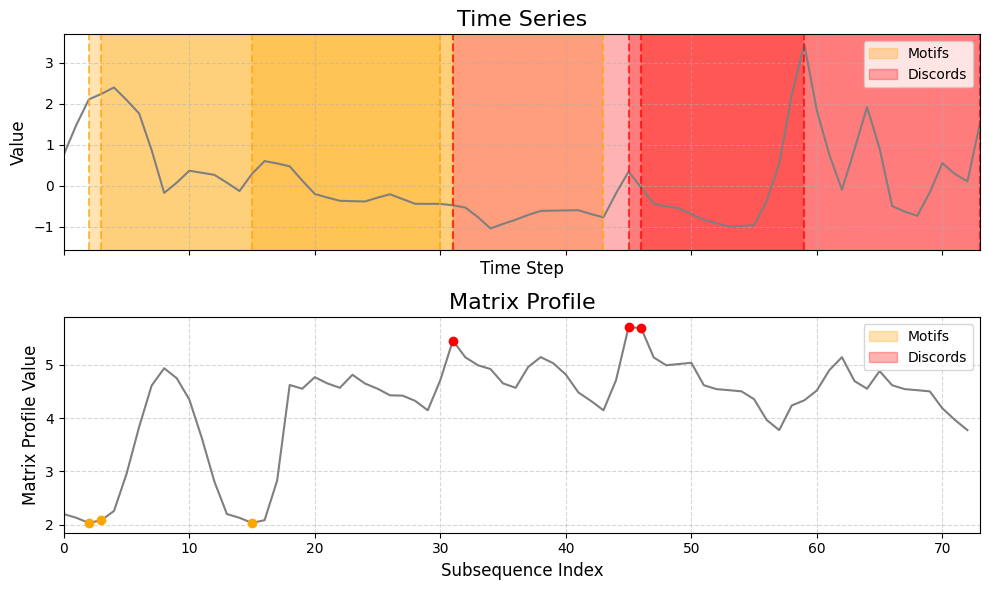

In [38]:
multi_series = df.drop(columns=cols_to_drop).values

# 2. Define the subsequence length 'm'
m = 28

# Correct Z-score normalization for each row
multi_series = (
    multi_series - np.mean(multi_series, axis=1, keepdims=True)
) / np.std(multi_series, axis=1, keepdims=True)

# 3. Iterate through each row and compute the matrix profile
for i, time_series in enumerate(multi_series):
    print(f"Processing Time Series #{i+1}...")
    
    # Compute the Matrix Profile for the current time series.
    # The st.stump function returns a tuple, we only need the first element (the matrix profile array)
    # for the plotting function. The other elements are the matrix profile indices, left/right indices.
    mp = st.stump(time_series, m)[:, 0]
    
    # Find the top motif (lowest value in the matrix profile)
    motif_index = np.argmin(mp)
    print(f"  - The most repeating motif starts at index: {motif_index}")
    
    # Find the top discord (highest value in the matrix profile)
    discord_index = np.argmax(mp)
    print(f"  - The most significant discord (anomaly) starts at index: {discord_index}")
    print("-" * 40)
    
print("\nTo visualize a specific time series, you can call the 'plot_matrix_profile' function manually.")
# Example: Plot the second time series which contains a simulated motif and discord.
plot_matrix_profile(multi_series[1], st.stump(multi_series[1], m)[:, 0], m)

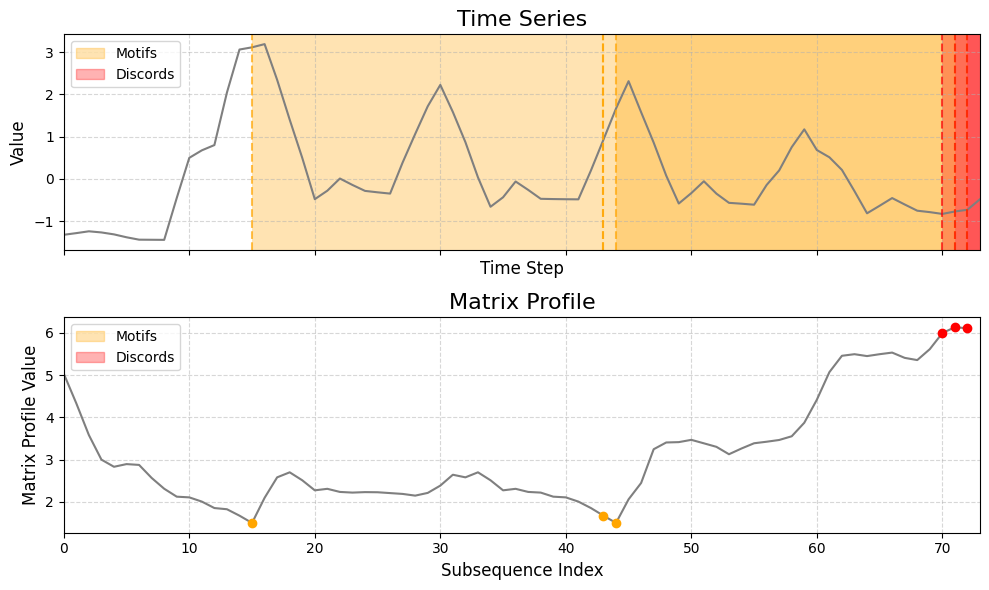

In [39]:
plot_matrix_profile(multi_series[1000], st.stump(multi_series[1000], m)[:, 0], m)

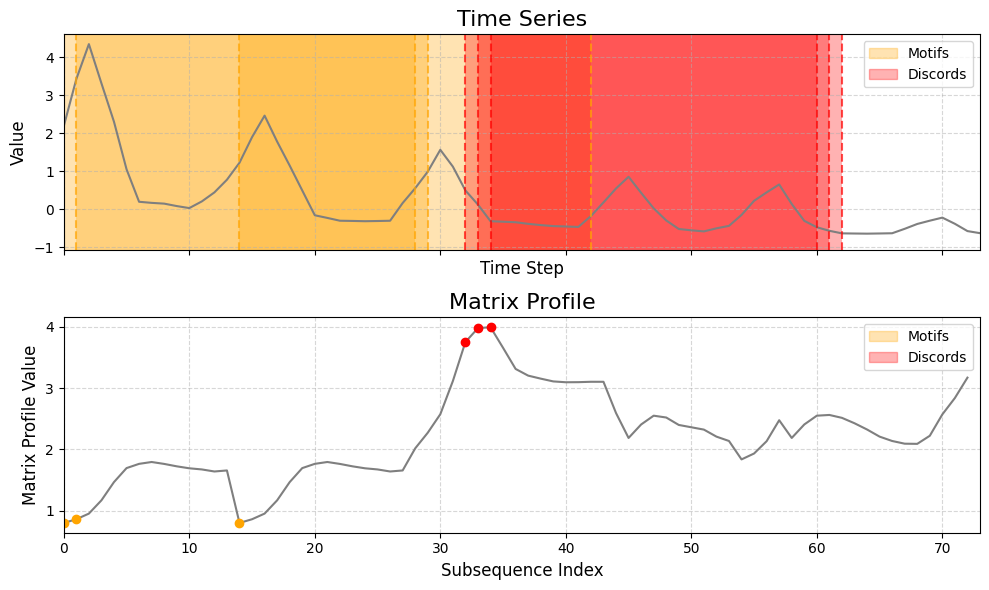

In [40]:
plot_matrix_profile(multi_series[150], st.stump(multi_series[150], m)[:, 0], m)

In [47]:
# For each time series, extract the top 3 motifs and discord subsequences and store them in a list
motifs_discords = []
for i, time_series in enumerate(multi_series):
    print(f"Extracting motifs and discords for Time Series #{i+1}...")
    
    # Compute the Matrix Profile for the current time series.
    mp = st.stump(time_series, m)[:, 0]
    
    # Find the top 3 motifs (lowest values in the matrix profile)
    motif_indices = np.argsort(mp)[:1]
    motifs = [time_series[idx:idx + m] for idx in motif_indices]
    
    # Find the top 3 discords (highest values in the matrix profile)
    discord_indices = np.argsort(mp)[-3:]
    discords = [time_series[idx:idx + m] for idx in discord_indices]
    
    motifs_discords.append({
        'motifs': motifs,
        'discords': discords
    })
    
    print(f"  - Extracted {len(motifs)} motifs and {len(discords)} discords.")
    print("-" * 40)

Extracting motifs and discords for Time Series #1...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #2...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #3...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #4...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #5...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #6...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #7...
  - Extracted 1 motifs and 3 discords.
----------------------------------------
Extracting motifs and discords for Time Series #8...
  - Extracted 1 

In [119]:
import numpy as np
import saxpy.paa
import saxpy.sax
from saxpy.alphabet import cuts_for_asize

# Extract only the top motif from each time series
motifs = [md['motifs'][0] for md in motifs_discords]

num_char = 6
alphabet_size = 5  # number of symbols in the SAX alphabet
cuts = cuts_for_asize(alphabet_size)

sax_motifs = []
for motif_arr in motifs:
    motif_arr = np.array(motif_arr, dtype=float)

    # PAA reduces motif (len=7) → 4 averaged values
    paa_motif = saxpy.paa.paa(motif_arr, num_char)

    # Map those 4 values to 4 letters
    sax_word = saxpy.sax.ts_to_string(paa_motif, cuts)
    sax_motifs.append(sax_word)

print("SAX representations of top motifs:", sax_motifs)

SAX representations of top motifs: ['eddeca', 'edcdbb', 'bbbbbb', 'bdbbdb', 'ecccbb', 'eddecc', 'bbbbbb', 'bbbbbb', 'bbbbbb', 'edcecc', 'eddecc', 'cbbbbb', 'eddecc', 'bbbbbc', 'cbbbbb', 'bbbbbb', 'eccecb', 'bacdbc', 'bbcbce', 'eccdcb', 'eddecc', 'cbbbbb', 'bbbbbb', 'edddcc', 'bcdbbc', 'eddecc', 'bbbbbb', 'eddecc', 'edcecc', 'bbbbbb', 'cbbcbb', 'eccdbb', 'cbbcbb', 'edcebb', 'cbbcbb', 'cbbcba', 'cbbbbb', 'bbbbbb', 'edcdbb', 'ececbc', 'eddecc', 'bbbbbb', 'eedecc', 'dbcdbb', 'dcbbbb', 'bbbbbb', 'cbbbbb', 'dcbcbb', 'cbbbbb', 'dcccbb', 'dbbbaa', 'bbaaaa', 'cbbbbb', 'eccecc', 'eddecc', 'edcecb', 'dbbcbb', 'eccedb', 'eddecc', 'dcccbb', 'eeeecc', 'eededd', 'bbbbbb', 'edcdcc', 'cbbbbb', 'bbbbbb', 'eddecc', 'edccbb', 'edcecc', 'cbbbbb', 'ecdecc', 'bbbbbb', 'eccdcb', 'bbbbbb', 'eddecc', 'edcecc', 'bbbbbb', 'cccbbc', 'cbbbbb', 'eddecc', 'cbbbbb', 'cbbbbb', 'edddcc', 'cbbbbb', 'edcecc', 'edddcc', 'bbbbbb', 'ecdecc', 'eddccb', 'eddecc', 'eddecc', 'bbbbbb', 'eccdbb', 'ecddcc', 'bbbbbb', 'bbbbbb', 'bbb

In [120]:
motifs[1]

array([ 2.10419982,  2.24011977,  2.39483716,  2.09118621,  1.762954  ,
        0.8679067 , -0.17462821,  0.07407637,  0.36615966,  0.31555117,
        0.26494268,  0.07407637, -0.12980355,  0.2909699 ,  0.60040467,
        0.54401236,  0.47316047,  0.12468486, -0.20065544, -0.28741285,
       -0.36694048, -0.37706217, -0.38429196, -0.29030476, -0.20933118,
       -0.32645368, -0.44068428, -0.44213023])

In [121]:
# Count occurrences, show top 10 most common
from collections import Counter
motif_counts = Counter(sax_motifs)
print("Top 10 most common motifs:")
for motif, count in motif_counts.most_common(10):
    print(f"Motif: {motif}, Count: {count}")

Top 10 most common motifs:
Motif: bbbbbb, Count: 243
Motif: eddecc, Count: 132
Motif: cbbbbb, Count: 118
Motif: dbbcbb, Count: 29
Motif: ecccbb, Count: 25
Motif: edddcc, Count: 24
Motif: ecdecc, Count: 23
Motif: edcecc, Count: 21
Motif: eccdbb, Count: 21
Motif: eedecc, Count: 21


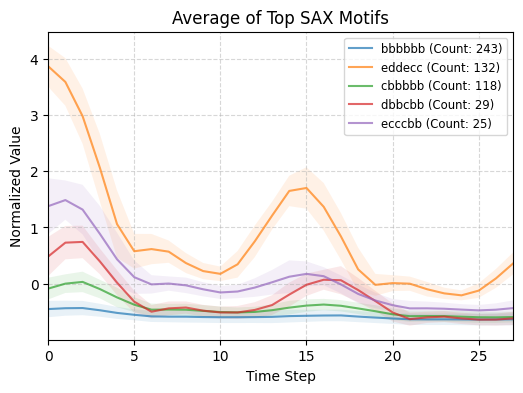

In [122]:
# Plot avg of top motifs by sax, with variance shaded
import matplotlib.pyplot as plt

top_motifs = motif_counts.most_common(5)  # Get top 5 motifs
plt.figure(figsize=(6, 4))
for motif, count in top_motifs:
    # Find all occurrences of this motif in the original motifs list
    occurrences = [motifs[i] for i, sax in enumerate(sax_motifs) if sax == motif]
    if occurrences:
        avg_motif = np.mean(occurrences, axis=0)
        plt.plot(avg_motif, label=f'{motif} (Count: {count})', alpha=0.7)
        # Shade variance
        std_motif = np.std(occurrences, axis=0)
        plt.fill_between(range(len(avg_motif)), avg_motif - std_motif, avg_motif + std_motif, alpha=0.1)
        
plt.title('Average of Top SAX Motifs')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend(fontsize='small')
plt.xlim(0, 27)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

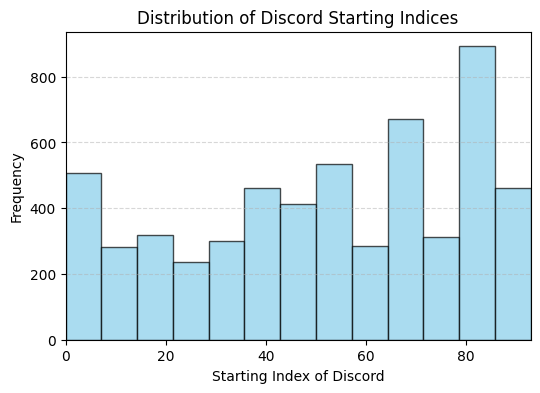

In [123]:
# Compute the indices of the top 3 discords for all time series
indices = []

for ts in multi_series:
    profile_matr = st.stump(ts, 7)[:, 0]
    indices = indices + [np.argsort(profile_matr)[-5:].tolist()]

n_last2 = 0
# % of discords in the last 14 time slots
for idcs in indices:
    for idx in idcs:
        if idx >= 99 - 28:
            n_last2 += 1
            
# Plot the distribution of discord starting indices
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
all_indices = [idx for sublist in indices for idx in sublist]
plt.hist(all_indices, bins=13, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Discord Starting Indices')
plt.xlabel('Starting Index of Discord')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xlim(0, 99 - 6)
plt.show()

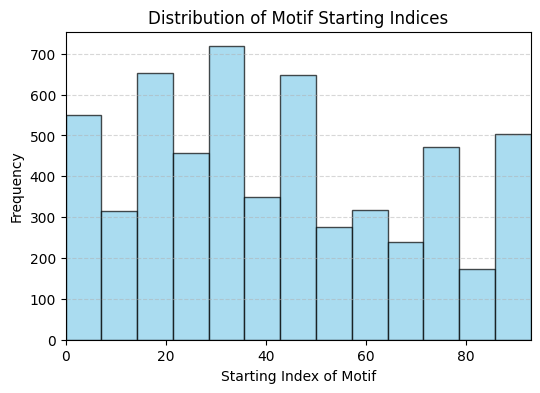

In [124]:
# Compute the indices of the top 3 motifs for all time series
motifs_indices = []

for ts in multi_series:
    profile_matr = st.stump(ts, 7)[:, 0]
    motifs_indices = motifs_indices + [np.argsort(profile_matr)[:5].tolist()]

     
# Plot the distribution of discord starting indices
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
all_motifs_indices = [idx for sublist in motifs_indices for idx in sublist]
plt.hist(all_motifs_indices, bins=13, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Motif Starting Indices')
plt.xlabel('Starting Index of Motif')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xlim(0, 99 - 6)
plt.show()

In [125]:
# 